In [13]:
import numpy as np
import matplotlib.pyplot as plt

import henon_map_cpp as hm
from tqdm import tqdm
import h5py
import numpy as np

In [3]:
omega_x  = 0.31
omega_y  = 0.32

epsilon = 1024.0
mu = 0.0
barrier = 1e4

In [4]:
x = np.linspace(0, 0.25, 100)
y = np.linspace(0, 0.25, 100)
xx, yy = np.meshgrid(x, y)

xx = xx.flatten()
yy = yy.flatten()
px = np.zeros_like(xx)
py = np.zeros_like(yy)

In [5]:
engine = hm.henon_tracker(100000, omega_x, omega_y, "sps")

creating gpu tracker


In [6]:
particles = hm.particles(xx, px, yy, py)

In [7]:
matrix_storage = hm.matrix_4d_vector(100*100, force_cpu=True)

In [8]:
m = engine.get_tangent_matrix(particles, mu)
for i in tqdm(range(10000)):
    engine.track(particles, 1, mu, barrier)
    matrix_storage.structured_multiply(engine, particles, mu)
    # for j in range(len(m)):
    #     m[j] = np.matmul(m2[j], m[j])

100%|██████████| 10000/10000 [01:27<00:00, 113.75it/s]


In [9]:
m = matrix_storage.get_matrix()

In [9]:
t = []
for i in range(len(m)):
    t.append(np.trace(np.matmul(m[i], m[i].T)))

t = np.array(t)

In [42]:
fli_base_x = np.array([1.0, 0.0, 0.0, 0.0])
fli_base_y = np.array([0.0, 0.0, 1.0, 0.0])
fli_base_px = np.array([0.0, 1.0, 0.0, 0.0])
fli_base_py = np.array([0.0, 0.0, 0.0, 1.0])

fli_x = []
fli_y = []
fli_px = []
fli_py = []

for i in tqdm(range(len(m))):
    fli_x.append(np.log10(np.linalg.norm(np.matmul(m[i], fli_base_x))))
    fli_y.append(np.log10(np.linalg.norm(np.matmul(m[i], fli_base_y))))
    fli_px.append(np.log10(np.linalg.norm(np.matmul(m[i], fli_base_px))))
    fli_py.append(np.log10(np.linalg.norm(np.matmul(m[i], fli_base_py))))

100%|██████████| 10000/10000 [00:00<00:00, 17793.56it/s]


In [53]:
t = []
for i in range(len(m)):
    t.append(np.trace(m[i]@m[i].T))

t = np.array(t)

In [56]:
BASE_X = np.array([1.0, 0.0, 0.0, 0.0])
BASE_PX = np.array([0.0, 0.0, 1.0, 0.0])
BASE_Y = np.array([0.0, 1.0, 0.0, 0.0])
BASE_PY = np.array([0.0, 0.0, 0.0, 1.0])

g = []
for test_m in m:
    vec_x = test_m.T @ BASE_X
    vec_px = test_m.T @ BASE_PX
    vec_y = test_m.T @ BASE_Y
    vec_py = test_m.T @ BASE_PY

    vec_x /= np.linalg.norm(vec_x)
    vec_px /= np.linalg.norm(vec_px)
    vec_y /= np.linalg.norm(vec_y)
    vec_py /= np.linalg.norm(vec_py)

    gali_matrix = np.array([
        vec_x, vec_px, vec_y, vec_py
    ])

    if np.any(np.isnan(gali_matrix)):
        g.append(np.nan)
    else:
        _, s, _ = np.linalg.svd(gali_matrix)
        g.append(np.prod(s))

g = np.asarray(g)

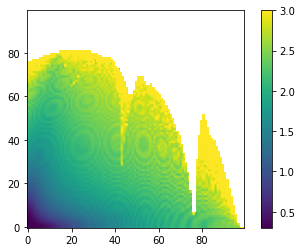

In [54]:
plt.imshow(np.log10(np.sqrt(t)).reshape(100, 100), origin="lower", vmax=3)
plt.colorbar()

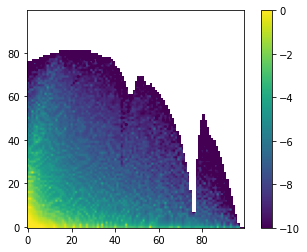

In [61]:
plt.imshow(np.log10(g).reshape(100, 100), origin="lower", vmin=-10)
plt.colorbar()

In [22]:
t2 = []
for i in range(len(m)):
    t2.append(np.trace(np.matmul(m[i].T, m[i])))

t2 = np.array(t2)

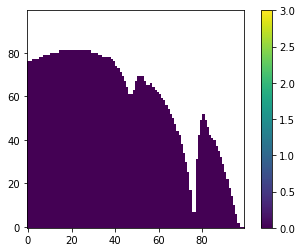

In [24]:
plt.imshow((np.sqrt(np.absolute(t-t2))).reshape(100, 100), origin="lower", vmax=3)
plt.colorbar()

In [16]:
m[2400]@m[2400].T

array([[   3.1641998 ,   -2.94481013,   18.6282872 ,  -21.18413836],
       [  -2.94481013,    8.03875266,  -36.50033071,   40.66201766],
       [  18.6282872 ,  -36.50033071,  190.33836383, -213.19816588],
       [ -21.18413836,   40.66201766, -213.19816588,  238.89152629]])

In [17]:
m[2400].T@m[2400]

array([[  1.28434914,  -1.46030907,   1.72593238,   2.44976025],
       [ -1.46030907,  30.05205812, -52.57752062, -95.17589125],
       [  1.72593238, -52.57752062,  95.1629295 , 172.73785702],
       [  2.44976025, -95.17589125, 172.73785702, 313.93350581]])

In [30]:
i = 2400
fli_base_x = np.array([1.0, 0.0, 0.0, 0.0])
print(np.linalg.norm(np.matmul(m[i], fli_base_x)))
print(np.linalg.norm((m[i] @ fli_base_x)))

1.133291285180019
1.133291285180019


In [11]:
m[0]

array([[ 1.00000000e+00,  3.67705866e-13,  0.00000000e+00,
         0.00000000e+00],
       [-3.67705866e-13,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         8.70192807e-13],
       [ 0.00000000e+00,  0.00000000e+00, -8.70192807e-13,
         1.00000000e+00]])

In [10]:
test_m = m[2400]
test_m

array([[ -0.51977476,   1.33283539,  -0.61333591,  -0.86104754],
       [ -0.96921028,  -0.57090291,   1.02156057,   2.39371426],
       [ -0.07675383,   3.42033998,  -6.40864056, -11.72872854],
       [  0.26253307,  -4.03124698,   7.25758147,  13.03453727]])

In [14]:
BASE_X = np.array([1.0, 0.0, 0.0, 0.0])
BASE_PX = np.array([0.0, 0.0, 1.0, 0.0])
BASE_Y = np.array([0.0, 1.0, 0.0, 0.0])
BASE_PY = np.array([0.0, 0.0, 0.0, 1.0])

vec_x = test_m.T @ BASE_X
vec_px = test_m.T @ BASE_PX
vec_y = test_m.T @ BASE_Y
vec_py = test_m.T @ BASE_PY

In [15]:
vec_x /= np.linalg.norm(vec_x)
vec_px /= np.linalg.norm(vec_px)
vec_y /= np.linalg.norm(vec_y)
vec_py /= np.linalg.norm(vec_py)

In [16]:
BASE_X = np.array([1.0, 0.0, 0.0, 0.0])
BASE_PX = np.array([0.0, 0.0, 1.0, 0.0])
BASE_Y = np.array([0.0, 1.0, 0.0, 0.0])
BASE_PY = np.array([0.0, 0.0, 0.0, 1.0])

vec_x = test_m.T @ BASE_X
vec_px = test_m.T @ BASE_PX
vec_y = test_m.T @ BASE_Y
vec_py = test_m.T @ BASE_PY

vec_x /= np.linalg.norm(vec_x)
vec_px /= np.linalg.norm(vec_px)
vec_y /= np.linalg.norm(vec_y)
vec_py /= np.linalg.norm(vec_py)

gali_matrix = np.array([
    vec_x, vec_px, vec_y, vec_py
])

_, s, _ = np.linalg.svd(gali_matrix)
np.prod(s)
gali_matrix

array([[-0.29220204,  0.74928074, -0.34479935, -0.48405553],
       [-0.00556336,  0.24791689, -0.46451821, -0.85013475],
       [-0.34184063, -0.20135755,  0.36030459,  0.84426342],
       [ 0.01698571, -0.26081888,  0.46956049,  0.84332553]])

In [48]:
my_matrix = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]
])

In [49]:
_, s, _ = np.linalg.svd(gali_matrix)
s

array([1.87212319, 0.66684159, 0.22464653, 0.00331553])

In [50]:
np.prod(s)

0.0009298441844789953

In [51]:
_, s, _ = np.linalg.svd(my_matrix)
s

array([1., 1., 1., 1.])

In [52]:
np.prod(s)

1.0

In [20]:
np.linalg.norm(vec_x)

1.0

In [46]:
f = h5py.File("/home/HPC/camontan/turchetti_paper/output/lyap_error.h5", "r")

In [47]:
f["999"].keys()

<KeysViewHDF5 ['tangent', 'tangent_rev']>

In [48]:
f["999/tangent"]

<HDF5 dataset "tangent": shape (10000, 4, 4), type "<f8">

In [96]:
random = np.random.normal(size=(1000 * 2 * 4)).reshape(1000 * 2, 4)
# normalize each row
for i in range(random.shape[0]):
    random[i] /= np.linalg.norm(random[i])

In [50]:
bool_list = np.empty(10000)
for i in tqdm(range(10000)):
    bool_list[i] = np.any(np.isnan(f[f"{999}/tangent_rev"][i]))

100%|██████████| 10000/10000 [00:14<00:00, 685.97it/s]


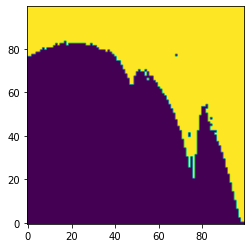

In [51]:
plt.imshow(bool_list.reshape(100, 100), origin="lower")

In [97]:
re = np.zeros((10000, 4))
for i in tqdm(range(1000)):
    re += (f[f"{999}/tangent_rev"][:]@f[f"{999-i}/tangent"][:])@random[i]
    re += f[f"{i}/tangent_rev"][:]@random[i+1000]

100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]


In [102]:
from numba import njit

In [135]:
@njit
def broadcast_matmul(mat, vec):
    result = np.empty_like(vec)
    for i in range(mat.shape[0]):
        result[i] = mat[i] @ vec[i]
    return result

bf = np.array([random[120] for i in range(10000)])

for i in tqdm(range(1000)):
    bf = broadcast_matmul(f[f"{i}/tangent"][:], bf) + random[None, i]

for i in tqdm(range(1000)):
    bf = broadcast_matmul(f[f"{999-i}/tangent_rev"][:], bf) + random[None, 1000+i]

100%|██████████| 1000/1000 [00:11<00:00, 88.16it/s]


In [136]:
the_re = np.empty(10000)
for i, r in enumerate(bf):
    the_re[i] = np.linalg.norm(r)

In [132]:
bf[0]

array([-1.36311572e+57, -1.36311572e+57, -1.36311572e+57, -1.36311572e+57])

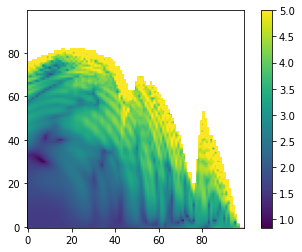

In [139]:
plt.imshow(np.log10(the_re).reshape(100, 100), origin="lower", vmax=5)
plt.colorbar()

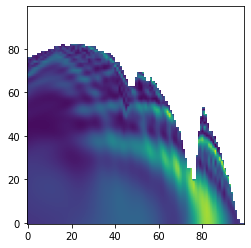

In [95]:
plt.imshow(the_re.reshape(100, 100), origin="lower")

In [18]:
np.any(np.logical_not(np.isnan(re)))

False

In [24]:
i = 999

f[f"{i}/tangent_rev"][:]@f[f"{999-i}/tangent"][:]@random[i]

array([[ 0.37565138, -0.8020021 , -0.01414599,  0.46419668],
       [ 0.3757743 , -0.801585  , -0.0141369 ,  0.4643505 ],
       [ 0.37589906, -0.80112538, -0.01412768,  0.46450828],
       ...,
       [ 0.38925782,         nan, -0.04408726,         nan],
       [ 0.38957312,         nan, -0.04425381,         nan],
       [ 0.38989028,         nan, -0.04442023,         nan]])

In [27]:
re

array([[ 1.15593994e+01,  8.29315765e+00, -8.37371681e-03,
         2.66452716e+01],
       [ 1.15619616e+01,  8.17193815e+00, -7.69082718e-03,
         2.66224007e+01],
       [ 1.15645656e+01,  8.04189435e+00, -7.03539060e-03,
         2.66110342e+01],
       ...,
       [            nan,             nan,             nan,
                    nan],
       [            nan,             nan,             nan,
                    nan],
       [            nan,             nan,             nan,
                    nan]])

In [72]:
test_a = np.array([
    [1,2],
    [3,4]
])
test_b = np.array([
    1,
    1
])
test_a @ test_b

array([3, 7])

In [85]:
mat_a = np.array([test_a for i in range(1000)])
mat_b = np.array([test_b for i in range(1000)])
mat_a @ test_b

array([[3, 7],
       [3, 7],
       [3, 7],
       ...,
       [3, 7],
       [3, 7],
       [3, 7]])

In [75]:
mat_a.shape

(1000, 2, 2)

In [76]:
mat_b.shape

(1000, 2)

In [79]:
np.matmul(mat_a, mat_b)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 2)

In [ ]:
def broadcast_matmul(mat, vec):
    result = np.empty_like(vec)
    for i in range(mat.shape[0]):
        vec[i] = mat[i] @ vec[i]
    return result

In [140]:
f = h5py.File("/home/HPC/camontan/turchetti_paper/output/tang_stuff.h5", "r")

In [152]:
f["100"].keys()

<KeysViewHDF5 ['fli_base_px', 'fli_base_py', 'fli_base_x', 'fli_base_y', 'gali', 'lyapunov_error']>

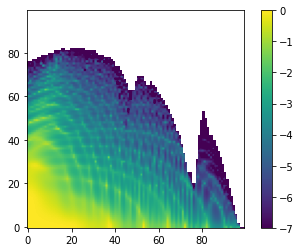

In [159]:
plt.imshow(np.log10(f["999"]["gali"][:]).reshape(100, 100), origin="lower", vmin=-7)
plt.colorbar()


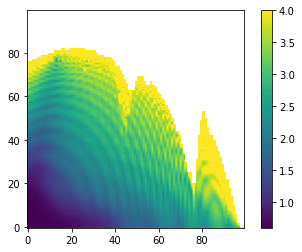

In [163]:
plt.imshow(np.log10(f["999"]["lyapunov_error"][:]).reshape(100, 100), origin="lower", vmax=4)
plt.colorbar()